In [1]:
# ! pip install pandas numpy matplotlib rasterio dotenv

# ! pip freeze > ../requirements.txt

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load Evnvironment

In [3]:
load_dotenv(".env")

ROOT_DATA_DIR = "../data" #os.getenv("ROOT_DATA_DIR")
CACHE_DIR = os.getenv("CACHE_DIR")

# Constants

In [4]:
CUT_OFF = 0.01

In [5]:
CACHE_DIR = f"{ROOT_DATA_DIR}{os.sep}{CACHE_DIR}"

LANDCOVER_GROWTH_2006_2010 = f"{CACHE_DIR}{os.sep}landcover_canada_growth_after_2005_to_2010_fire_in_2010.csv"
LANDCOVER_GROWTH_2011_2015 = f"{CACHE_DIR}{os.sep}landcover_canada_growth_after_2010_to_2015_fire_in_2015.csv"
LANDCOVER_GROWTH_2016_2020 = f"{CACHE_DIR}{os.sep}landcover_canada_growth_after_2015_to_2020_fire_in_2020.csv"
LANDCOVER_GROWTH = [
    LANDCOVER_GROWTH_2006_2010,
    LANDCOVER_GROWTH_2011_2015,
    LANDCOVER_GROWTH_2016_2020,
]

YEARS = [
    2010,
    2015,
    2020
]

In [6]:
LANDCOVER_COLORS = {
    0:"#FFFFFF",
    1:"#1B5E20", 
    2:"#689F38", 
    3:"#9CCC65", 
    4:"#C5E1A5", 
    5:"#66BB6A", 
    6:"#004D40", 
    7:"#A5D6A7", 
    8:"#808000",
    9:"#005000", 
    10:"#2E7D32", 
    11:"#00897B", 
    12:"#004D40", 
    13:"#B2DFDB", 
    14:"#4DB6AC", 
    15:"#795548", 
    16:"#808080", 
    17:"#000000", 
    18:"#000080", 
    19:"#D0D0F0"
}

In [7]:
LANDCOVER_LABELS = {
    0: "Not Canada",
    1: "Temperate or Sub-Polar\nNeedleleaf Forest",
    2: "Sub-Polar\nTaiga Needleleaf Forest",
    3: "3 - No Name Yet",
    4: "4 - No Name Yet",
    5: "Temperate or Sub-Polar\nBroadleaf Deciduous Forest",
    6: "Mixed Forest",
    7: "7 - No Name Yet",
    8: "Temperate or\nSub-Polar Shrubland",
    9: "9 - No Name Yet",
    10: "Temperate or\nSub-Polar Grassland",
    11: "Sub-Polar or Polar\nShrubland-Lichen-Moss",
    12: "Sub-Polar or Polar\nGrassland-Lichen-Moss",
    13: "Sub-Polar or Polar\nBarren-Lichen-Moss",
    14: "Wetland",
    15: "Cropland",
    16: "Baren Land",
    17: "Urban building",
    18: "Water",
    19: "Snow and Ice"
}

# Helper Functions

In [8]:
def get_year_df(
    landcover_growth_file:str,
    index_col_count:str = "ID",
    color_dict:dict = LANDCOVER_COLORS,
    label_dict:dict = LANDCOVER_LABELS,
    cut_off:float = CUT_OFF,
):
    # read data
    landcover_growth_df = pd.read_csv(
        landcover_growth_file
    )

    # add color and label data 
    landcover_growth_df["COLOR"] = landcover_growth_df[index_col_count].apply(lambda id: f"{color_dict[id]}DD")
    landcover_growth_df["LABEL"] = landcover_growth_df[index_col_count].apply(lambda id: label_dict[id])

    # drop values less than cut off
    landcover_growth_df = landcover_growth_df[landcover_growth_df['COUNT'] > landcover_growth_df['COUNT'].max() * cut_off]

    # discard water bodies
    landcover_growth_df = landcover_growth_df[landcover_growth_df['ID'] != 18]

    # sort by count
    landcover_growth_df = landcover_growth_df.sort_values(
        "COUNT",
        ascending = False
    )

    # covert to km^2
    landcover_growth_df["COUNT"] = landcover_growth_df["COUNT"] * 0.0009


    return landcover_growth_df

In [9]:
def plot_growth_after_burn_donut(
    landcover_df,
    year:int,
    fig_name:str,
    title:str = "",
    radius:float = 1.5,
    donut_width:float = 0.5,
    start_angle:float = 0,
    figsize:tuple = (10, 10),
    year_font_size = 20,
    total_col:str = "COUNT",
    color_col:str = "COLOR",
    id_col:str = "ID",
    label_col:str = "LABEL",
    cut_off:float = 5,
    label_dist:float = 1,
    label_font:float = 15
):
    fig, ax = plt.subplots(
        figsize = figsize
    )

    # plot growth area
    wedges, texts, _percent = ax.pie(
        landcover_df[total_col], 
        radius = radius, 
        startangle = start_angle,
        colors = landcover_df[color_col],
        wedgeprops = dict(
            width = radius - donut_width, 
        ),
        # textprops=dict(
        #     color = 'black', 
        #     fontsize = label_font, 
        #     # weight = 'bold'
        # ),
        # pctdistance = 0.85,
        # labeldistance = 0.6,
        # autopct = '%0.2f%%'
        autopct = ''
    )

    # add year label
    ax.text(
        x = 0,
        y = 0,
        s = f"{year}\nLand Cover\nGrowth After\n{year-4}-{year}\nHistoric Fires",
        fontsize = year_font_size,
        fontweight = 'bold',
        va = 'center',
        ha = 'center',
    )

    for i, wedge in enumerate(wedges):
        ang = (wedge.theta2 + wedge.theta1) / 2
        wegde_angle = (wedge.theta2 - wedge.theta1) / 360 * 100

        rotation = ang if ang <= 180 else ang - 180
        if 90 < ang < 270:
            rotation = ang + 180
            alignment = 'right'
        else:
            rotation = ang
            alignment = 'left'

        rand_move = 0
        wedge_label = ""
        is_bold = True
        if wegde_angle < cut_off:
            rand_move = 0.2 if i%2 == 0 else -0.2
            wedge_label = f"{landcover_df.iloc[i][id_col]}: {landcover_df.iloc[i][total_col]:,.1f}$km^2$"
        else:
            wedge_label = f"{landcover_df.iloc[i][id_col]}: {landcover_df.iloc[i][label_col]}\n{landcover_df.iloc[i][total_col]:,.1f}$km^2$ \n{wegde_angle:.1f}%"
            
        x = (label_dist + rand_move) * np.cos(np.deg2rad(ang))
        y = (label_dist + rand_move) * np.sin(np.deg2rad(ang))
        ax.text(
            x, 
            y, 
            wedge_label, 
            ha = 'center', 
            va = 'center', 
            rotation = rotation,
            rotation_mode = 'anchor',
            color = 'black', 
            fontsize = label_font, 
            # weight = 'bold' if is_bold else None
        )


    plt.savefig(
        fig_name, 
        transparent = True,
        bbox_inches = 'tight', # compress the content  
        pad_inches = 0, # have no extra margin
    )


    # add title
    if title == "":
        title = f"Land Cover Growth in {year} for Historic Fires between {year-4}-{year}"
    # ax.set_title(title)
    
    plt.show()
    

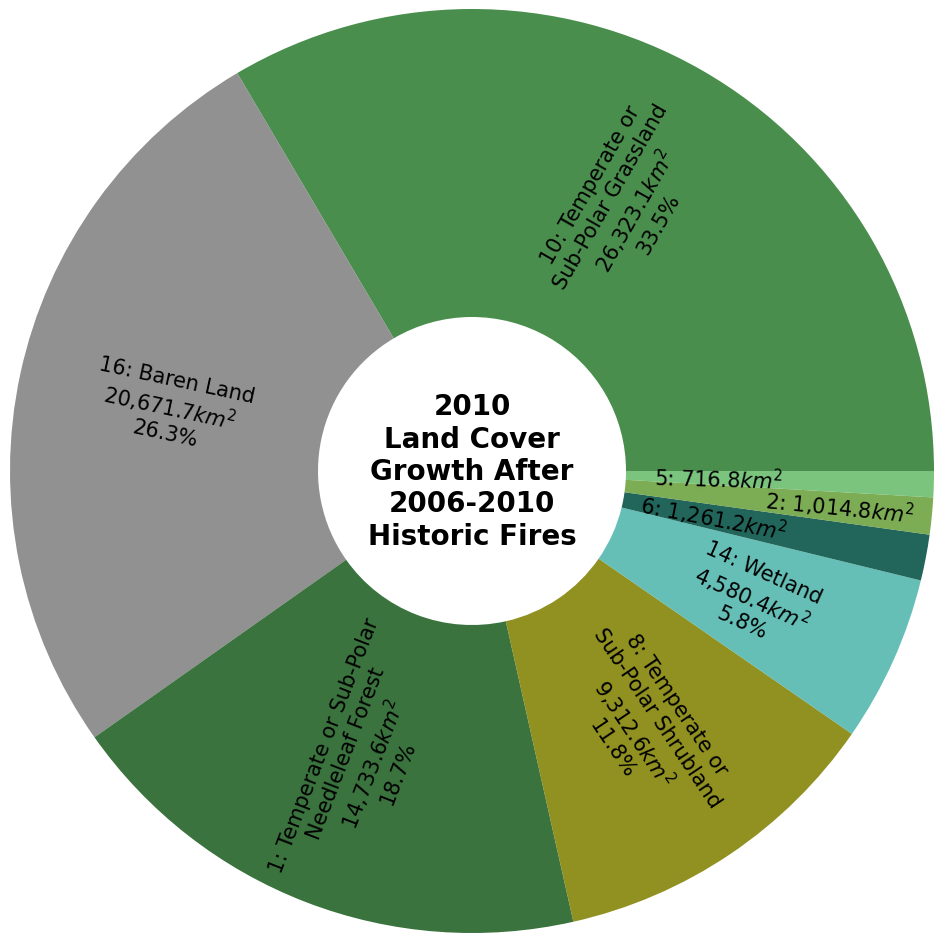

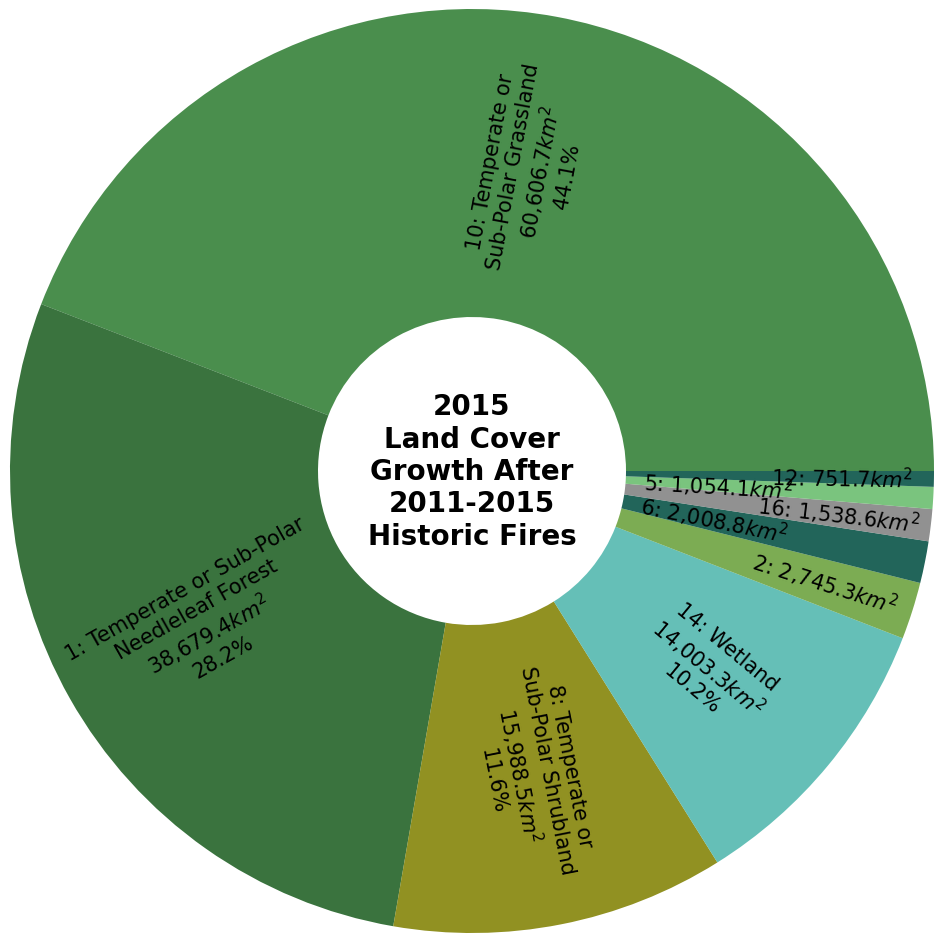

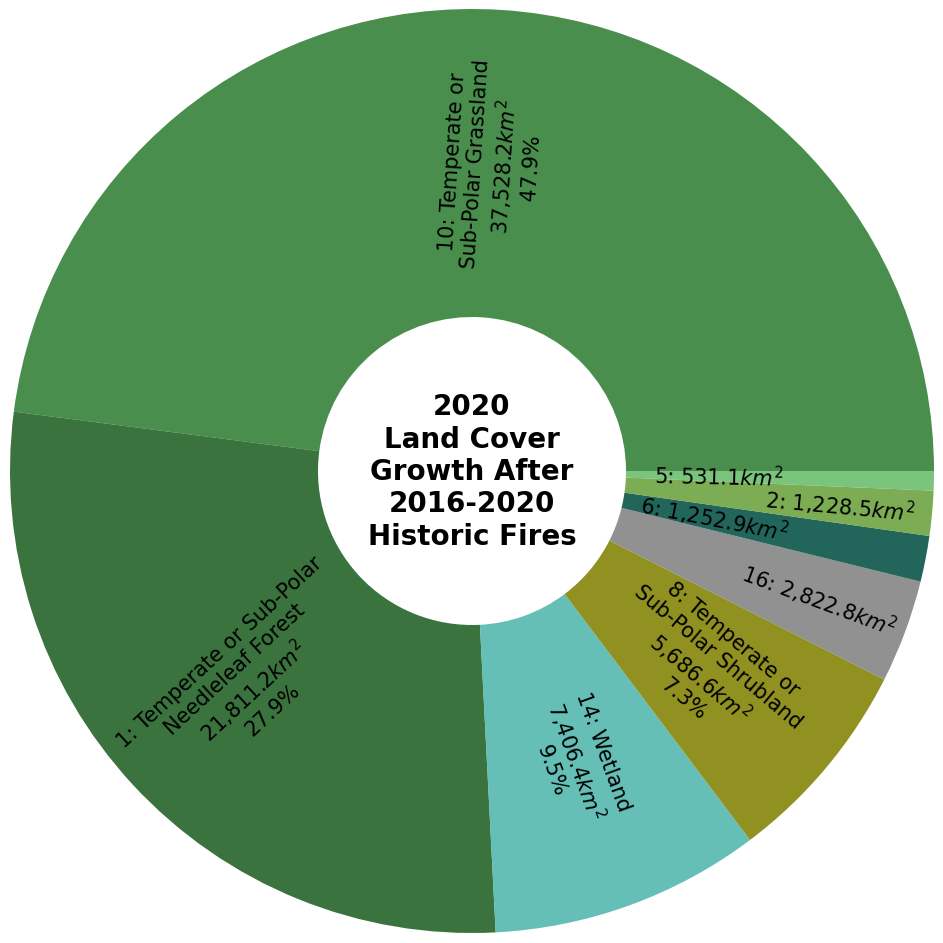

In [10]:
for growth_file, year in zip(LANDCOVER_GROWTH, YEARS):
    df = get_year_df(
        landcover_growth_file = growth_file,
    )

    plot_growth_after_burn_donut(
        landcover_df = df,
        year = year,
        start_angle = 0,
        fig_name = f"../assets/figures/landcover_canada_only_grown_{year}_historic_fire_{year-4}_{year}.png"
    )